# **1. INTRODUCTION ** 

PlayerUnknown's Battlegrounds (PUBG) is an online multiplayer battle royale game developed and published by PUBG Corporation, a subsidiary of South Korean video game company Bluehole. The game is based on previous mods that were created by Brendan "PlayerUnknown" Greene for other games using the film Battle Royale for inspiration, and expanded into a standalone game under Greene's creative direction. In the game, up to one hundred players parachute onto an island and scavenge for weapons and equipment to kill others while avoiding getting killed themselves. The available safe area of the game's map decreases in size over time, directing surviving players into tighter areas to force encounters. The last player or team standing wins the round.

The game was first released for Microsoft Windows via Steam's early access beta program in March 2017, with a full release on December 20, 2017. That same month, the game was released by Microsoft Studios for the Xbox One via its Xbox Game Preview program, and officially released in September 2018. The same year, a port for the PlayStation 4 was released, in addition to two different mobile versions for Android and iOS. The game is one of the best-selling of all time, with over fifty million sold across all platforms by June 2018. In addition, the Windows version holds a peak concurrent player count of over three million on Steam, which is an all-time high on the platform.

# PROBLEM DESCRIPTION

Over 65,000 games' worth of anonymized player data, split into training and testing sets, and asked to predict final placement from final in-game stats and initial player ratings. What's the best strategy to win in PUBG? Should you sit in one spot and hide your way into victory, or do you need to be the top shot? Let's let the data do the talking!

# **2. EXPLANATORY DATA ANALYSIS**

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import gc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from mlxtend.evaluate import feature_importance_permutation
from sklearn.model_selection import GridSearchCV
import gc
import os
import sys
#Figures Inline and Visualization style
%matplotlib inline
sb.set()

In [2]:
train = pd.read_csv('../input/train_V2.csv')
test = pd.read_csv('../input/test_V2.csv')

**Variables in the Dataset**
* Id - Player’s Id
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* DBNOs - Number of enemy players knocked.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify match. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [3]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


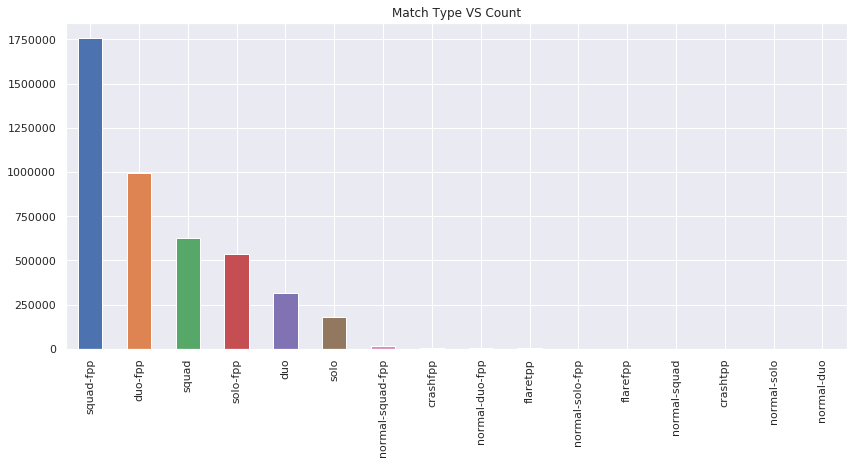

In [4]:
train['matchType'].value_counts().plot.bar(title='Match Type VS Count', figsize=(14,6))

**Take Away:**   Majority of players prefer squad  game followed by Duo. Solo game is the least preferred. 

In [5]:
train.count()

Id                 4446966
groupId            4446966
matchId            4446966
assists            4446966
boosts             4446966
damageDealt        4446966
DBNOs              4446966
headshotKills      4446966
heals              4446966
killPlace          4446966
killPoints         4446966
kills              4446966
killStreaks        4446966
longestKill        4446966
matchDuration      4446966
matchType          4446966
maxPlace           4446966
numGroups          4446966
rankPoints         4446966
revives            4446966
rideDistance       4446966
roadKills          4446966
swimDistance       4446966
teamKills          4446966
vehicleDestroys    4446966
walkDistance       4446966
weaponsAcquired    4446966
winPoints          4446966
winPlacePerc       4446965
dtype: int64

WinPlacePerc is the only column with missing value. Since the number of missing values is only 1 and the data is really big, simply delete the row.

In [6]:
train.dropna(inplace=True)

In [7]:
test.count()

Id                 1934174
groupId            1934174
matchId            1934174
assists            1934174
boosts             1934174
damageDealt        1934174
DBNOs              1934174
headshotKills      1934174
heals              1934174
killPlace          1934174
killPoints         1934174
kills              1934174
killStreaks        1934174
longestKill        1934174
matchDuration      1934174
matchType          1934174
maxPlace           1934174
numGroups          1934174
rankPoints         1934174
revives            1934174
rideDistance       1934174
roadKills          1934174
swimDistance       1934174
teamKills          1934174
vehicleDestroys    1934174
walkDistance       1934174
weaponsAcquired    1934174
winPoints          1934174
dtype: int64

In [8]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06
mean,2.338150e-01,1.106908e+00,1.307172e+02,6.578757e-01,2.268196e-01,1.370148e+00,4.759936e+01,5.050062e+02,9.247835e-01,5.439553e-01,2.299760e+01,1.579507e+03,4.450468e+01,4.300760e+01,8.920103e+02,1.646590e-01,6.061158e+02,3.496092e-03,4.509323e+00,2.386841e-02,7.918209e-03,1.154218e+03,3.660488e+00,6.064603e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746293e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587388e+02,2.382810e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261158e-02,1.183497e+03,2.456543e+00,7.397005e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.330000e+02,2.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.910000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


**CORELATION MATRIX, HEAT MAP**

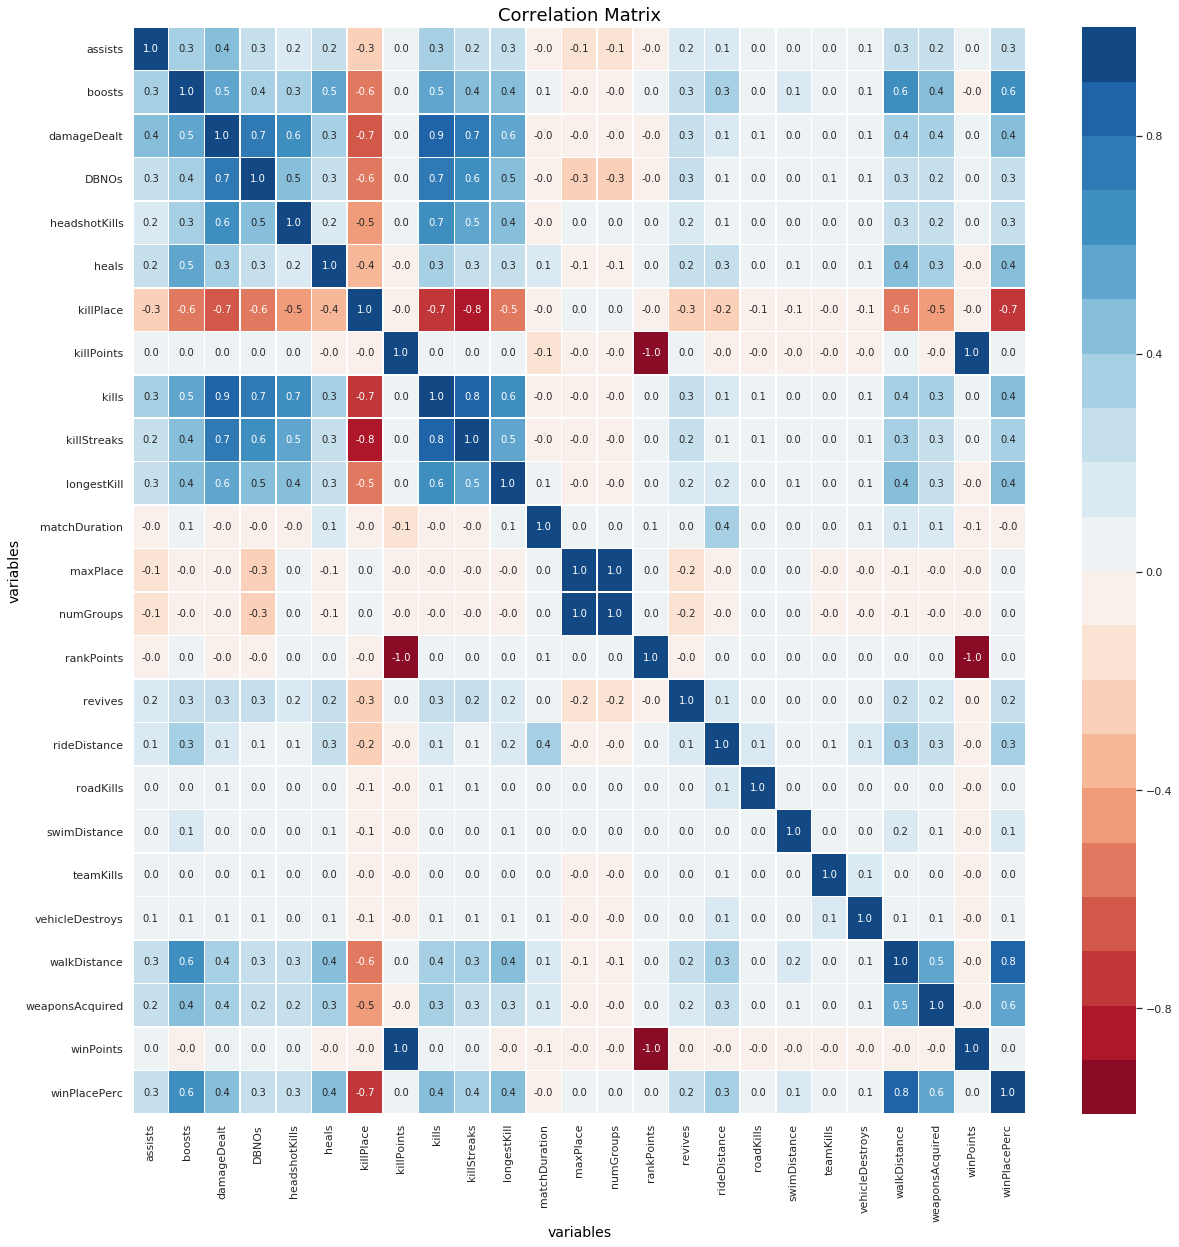

In [9]:
f,ax = plt.subplots(figsize=(20, 20))
sb.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap=sb.color_palette("RdBu", 20))
ax.set_xlabel('variables', size=14, color="black")
ax.set_ylabel('variables', size=14, color="black")
ax.set_title('Correlation Matrix', size=18, color="black")
plt.show()

**Take Away** 
* WinPoints and RankPoints are the **most negatively corelated**
* winPoints&killPoints, numGroups&maxPlace are the **most positively corelated variables**
* walkDistance in the **most positively independent corelated** variable with the dependant variable winPlacePerc
* killPlace is the **most negatively corelated independent** variable with the dependant variable winPlacePerc


PUBG is all about Killing the opponents and surviving till the end. So let's  have a closer look at these variables.

In [10]:
print("In the average, a person kills {:.4f} players, About 99% players have a kill count less than or equal  to {}, while the most kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

In the average, a person kills 0.9248 players, About 99% players have a kill count less than or equal  to 7.0, while the most kills ever recorded is 72.


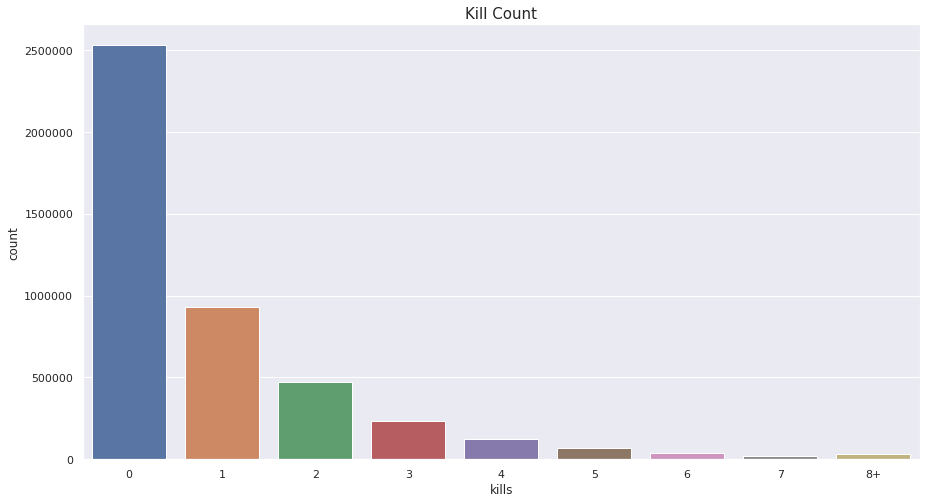

In [11]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,8))
sb.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

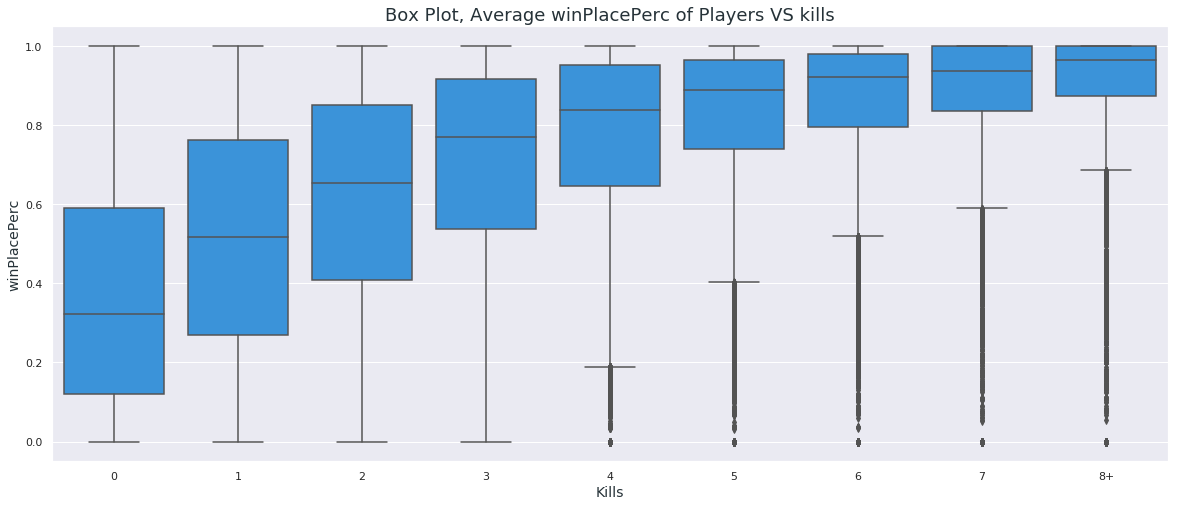

In [12]:
data = train[['kills','winPlacePerc']].copy()
data.loc[data['kills'] > data['kills'].quantile(0.99), 'kills'] = '8+'
order = data.groupby('kills').mean().reset_index()['kills']
fig, ax = plt.subplots(figsize=(20,8))
a = sb.boxplot(x='kills', y='winPlacePerc', data=data, ax=ax, color="#2196F3", order=order)
ax.set_xlabel('Kills', size=14, color="#263238")
ax.set_ylabel('winPlacePerc', size=14, color="#263238")
ax.set_title('Box Plot, Average winPlacePerc of Players VS kills', size=18, color="#263238")
plt.show()

**Take Away** Major Portion of the players in the train data  (Around 25lakh) finish the match without a single kill.  Around 9 lakh manages to get a kill. 99% Players have kills less than or equal to 7. Only 1% players managed to kill 8 or more than 8. The maximum kill recorded for a player is 72 in the train data.  Is it really possible to kill 72 out of maximum 100 players in a game? Let's have a look at the player data.

In [13]:
train[train['kills']==72]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
3431247,06308c988bf0c2,4c4ee1e9eb8b5e,6680c7c3d17d48,7,4,5990.0,0,64,10,1,0,72,7,78.23,1800,normal-squad,15,15,1500,0,0.0,0,0.0,0,0,728.1,35,0,1.0


**Take Away ** The Player has 72 kills and 7 assists which means he himself has contributed to 79kills. His squad won the match. The Player has a damageDealt that is about 30x higher than the standard deviation, which means the player survived even after suffering heavy damage which is not possible in real case. 64 kills out of 72 are headShotKills. This opens two possibilities, He either used sniper for head shot kill from long distance or killed from point blank distance. The heavy damage that the player dealt indicates the second possibility.  Also the number of weapons acquired by the player is very high compared to the mean and standard deviation of the data. If the player was a sniper, Then he wouldn't have acquired this much weapons. So most likely the player has made some sort of cheating in the game. 

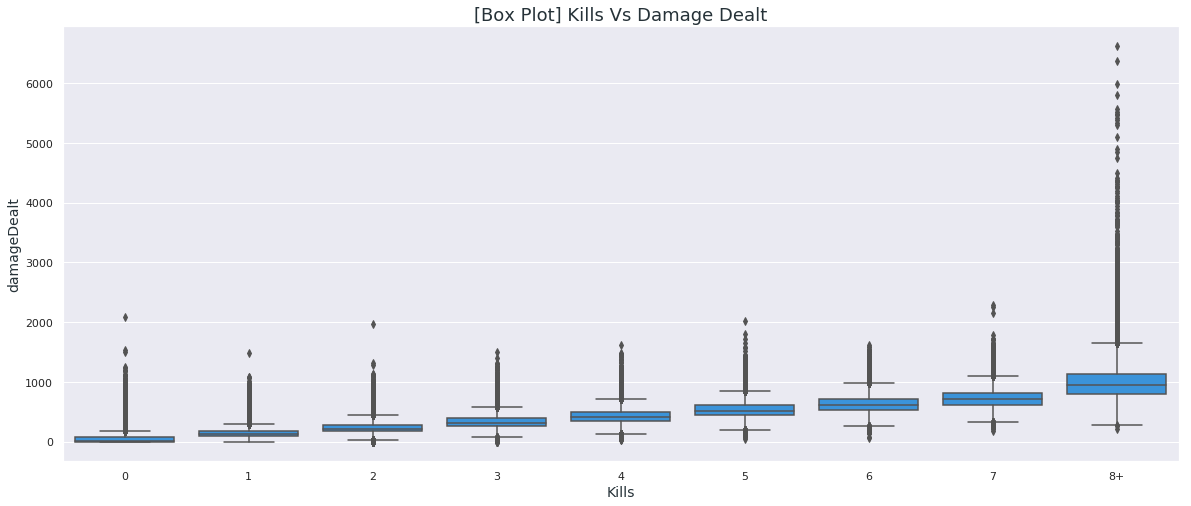

In [14]:
data = train[['kills','damageDealt']].copy()
data.loc[data['kills'] > data['kills'].quantile(0.99), 'kills'] = '8+'
x_order = data.groupby('kills').mean().reset_index()['kills']
fig, ax = plt.subplots(figsize=(20,8))
a = sb.boxplot(x='kills', y='damageDealt', data=data, ax=ax, color="#2196F3", order=x_order)
ax.set_xlabel('Kills', size=14, color="#263238")
ax.set_ylabel('damageDealt', size=14, color="#263238")
ax.set_title('[Box Plot] Kills Vs Damage Dealt', size=18, color="#263238")
plt.show()

**Take Away** kills increase proportionaly with damageDealt.  The relationship is understandable since more kills means more encounters with enemies and during these encounters, the player can receive a lot of damage.  The data contain many outliers. Most probably due to cheaters in the game.  DamageDealt can be used to detect hackers. Players with extremely high damageDealt might have did some sort of cheating in the game since they have very high winplaceprc and a bulk portion of these players won the game. 

99th percentile of damageDealt is 776.2


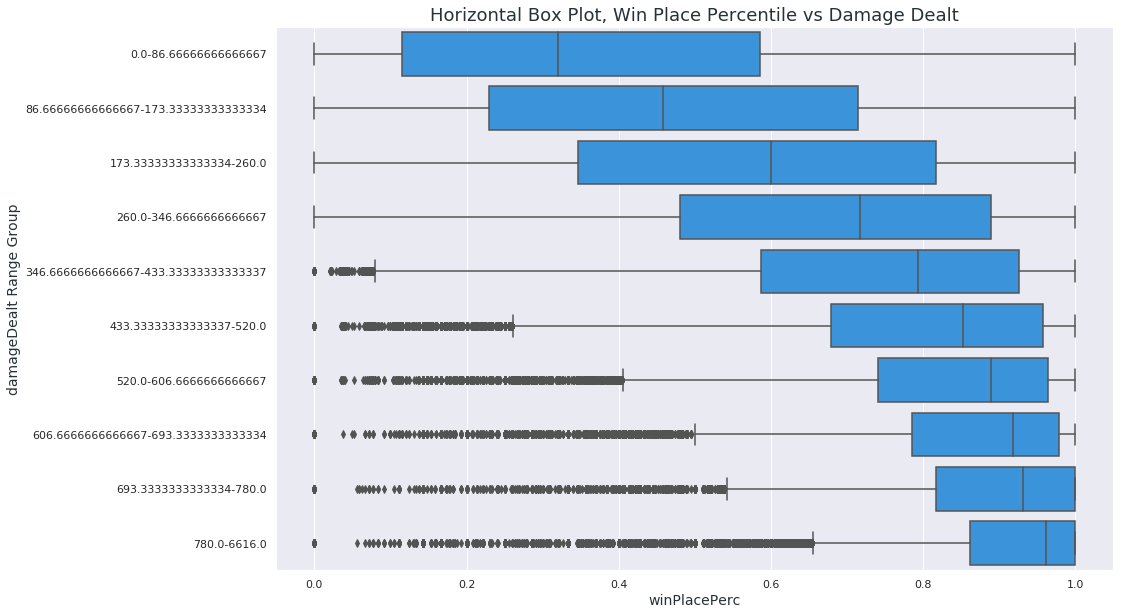

In [15]:
data = train[['damageDealt','winPlacePerc']].copy()

print("99th percentile of damageDealt is {}".format(data['damageDealt'].quantile(0.99)))

cut = np.linspace(0,780,10)
cut= np.append(cut, 6616)

data['damageDealtGrouping'] = pd.cut(data['damageDealt'],
                                 cut,
                                 labels=["{}-{}".format(a, b) for a, b in zip(cut[:10], cut[1:])],
                                 include_lowest=True
                                )

fig, ax = plt.subplots(figsize=(15,10))
sb.boxplot(x="winPlacePerc", y="damageDealtGrouping", data=data, ax=ax, color="#2196F3")
ax.set_xlabel('winPlacePerc', size=14, color="#263238")
ax.set_ylabel('damageDealt Range Group', size=14, color="#263238")
ax.set_title('Horizontal Box Plot, Win Place Percentile vs Damage Dealt', size=18, color="#263238")
plt.gca().xaxis.grid(True)
plt.show()

**Take Away** Players with high damageDealt have high winPlacePerc. Players who have survived till the end have higher chance for encounters and hence the damageDealt can be higher. 

99th percentile of walkDistance is 4396.0


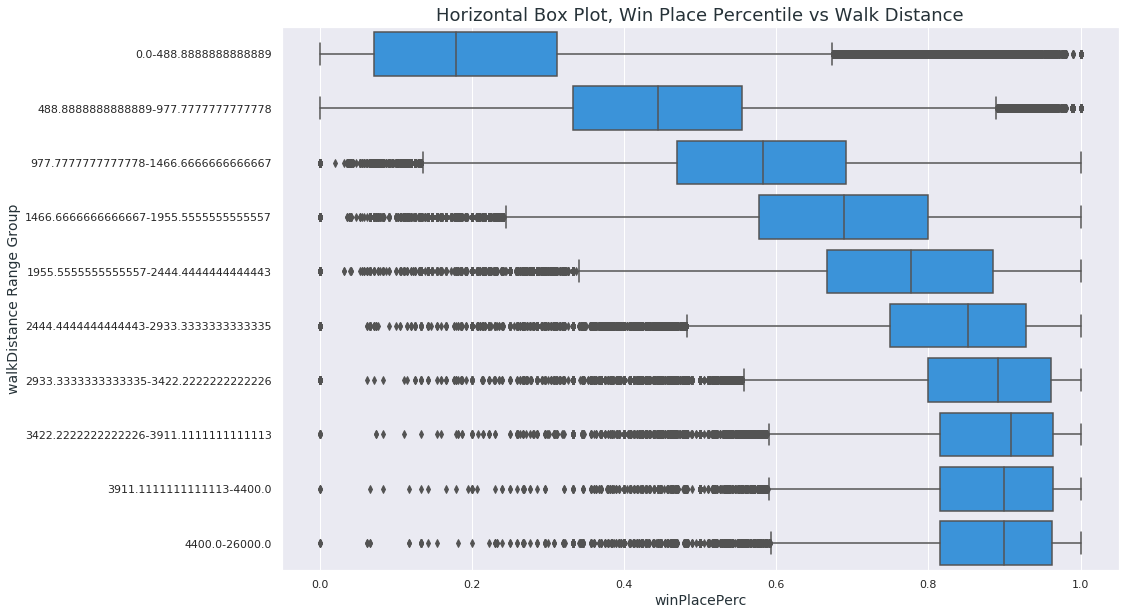

In [16]:
data = train[['walkDistance','winPlacePerc']].copy()

print("99th percentile of walkDistance is {}".format(data['walkDistance'].quantile(0.99)))

cut = np.linspace(0,4400,10)
cut= np.append(cut, 26000)
data['walkDistanceGrouping'] = pd.cut(data['walkDistance'],
                                 cut,
                                 labels=["{}-{}".format(a, b) for a, b in zip(cut[:10], cut[1:])],
                                 include_lowest=True
                                )

fig, ax = plt.subplots(figsize=(15,10))
sb.boxplot(x="winPlacePerc", y="walkDistanceGrouping", data=data, ax=ax, color="#2196F3")
ax.set_xlabel('winPlacePerc', size=14, color="#263238")
ax.set_ylabel('walkDistance Range Group', size=14, color="#263238")
ax.set_title('Horizontal Box Plot, Win Place Percentile vs Walk Distance', size=18, color="#263238")
plt.gca().xaxis.grid(True)
plt.show()

**Take Away** Walk Distance definitely has positive corelation with WIn. As walk distance increases, Win Place also increases. 

99th percentile of killPlace is 96.0


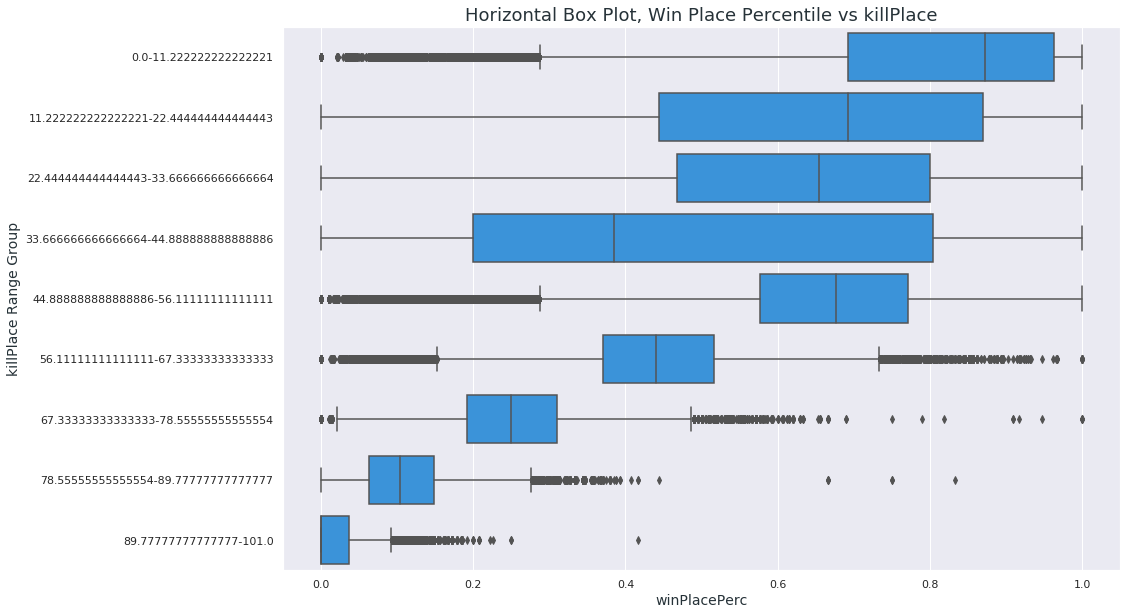

In [17]:
data = train[['killPlace','winPlacePerc']].copy()

print("99th percentile of killPlace is {}".format(data['killPlace'].quantile(0.99)))

cut = np.linspace(0,101,10)
data['killPlaceGrouping'] = pd.cut(data['killPlace'],
                                 cut,
                                 labels=["{}-{}".format(a, b) for a, b in zip(cut[:10], cut[1:])],
                                 include_lowest=True
                                )

fig, ax = plt.subplots(figsize=(15,10))
sb.boxplot(x="winPlacePerc", y="killPlaceGrouping", data=data, ax=ax, color="#2196F3")
ax.set_xlabel('winPlacePerc', size=14, color="#263238")
ax.set_ylabel('killPlace Range Group', size=14, color="#263238")
ax.set_title('Horizontal Box Plot, Win Place Percentile vs killPlace', size=18, color="#263238")
plt.gca().xaxis.grid(True)
plt.show()

**Take Away**  Increase in Killplace has a negative corelation with winplacePerc. 

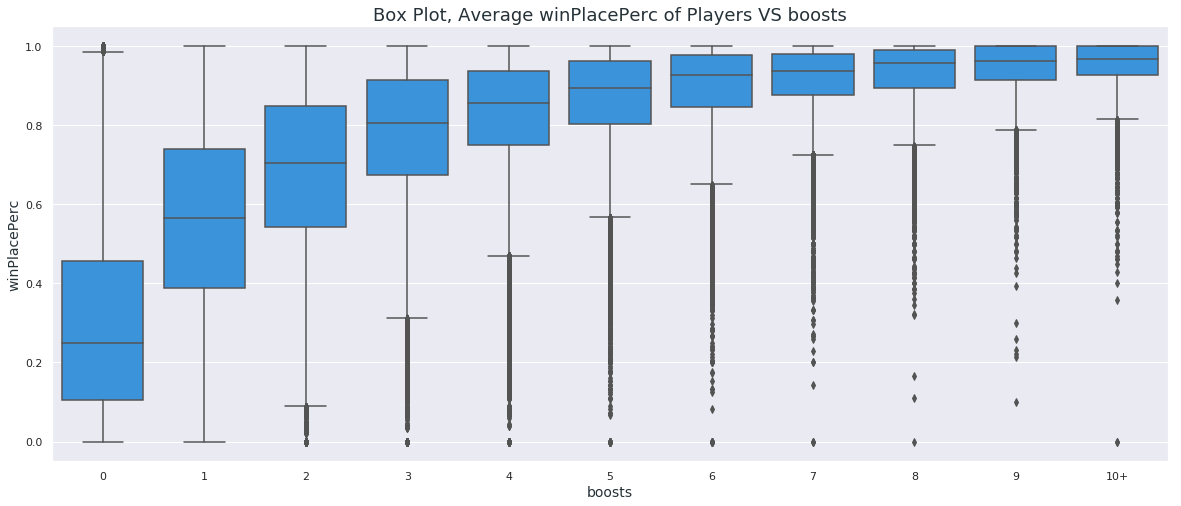

In [18]:
data = train[['boosts','winPlacePerc']].copy()
data.loc[data['boosts'] >= 10, 'boosts'] = '10+'
order = data.groupby('boosts').mean().reset_index()['boosts']
fig, ax = plt.subplots(figsize=(20,8))
a = sb.boxplot(x='boosts', y='winPlacePerc', data=data, ax=ax, color="#2196F3", order=order)
ax.set_xlabel('boosts', size=14, color="#263238")
ax.set_ylabel('winPlacePerc', size=14, color="#263238")
ax.set_title('Box Plot, Average winPlacePerc of Players VS boosts', size=18, color="#263238")
plt.show()

**Take Away** Players who used 10+ boosts has the highest win probability with a mean of .9. So players  should try to use more boosts inthe game as it will help increase damage Dealt and recover damage quicker.  

12.0


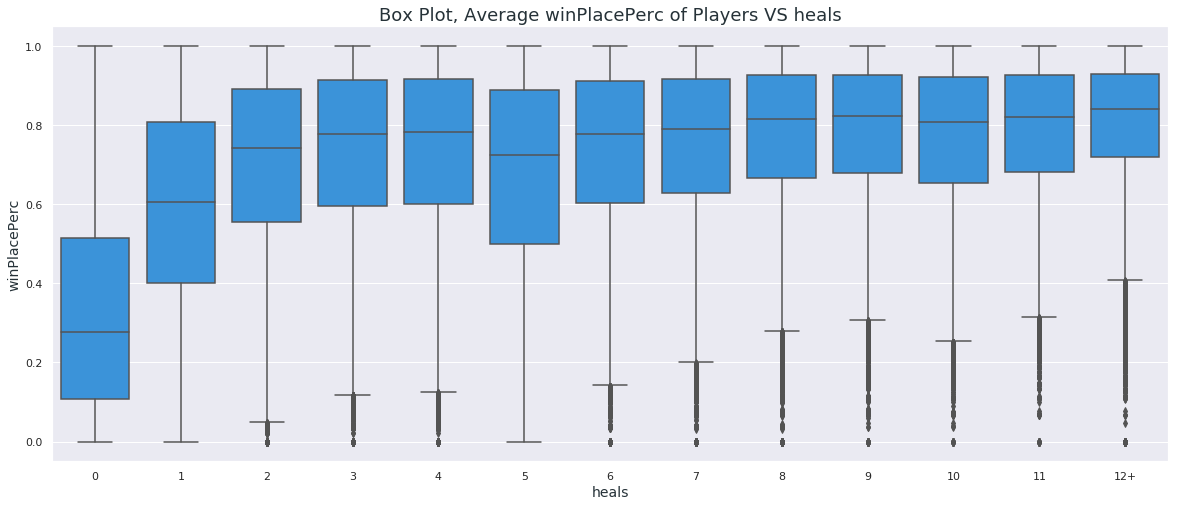

In [19]:
data = train[['heals','winPlacePerc']].copy()
print(data['heals'].quantile(0.99))
data.loc[data['heals'] >= 12, 'heals'] = '12+'
order = data.groupby('heals').mean().reset_index()['heals']
fig, ax = plt.subplots(figsize=(20,8))
a = sb.boxplot(x='heals', y='winPlacePerc', data=data, ax=ax, color="#2196F3", order=order)
ax.set_xlabel('heals', size=14, color="#263238")
ax.set_ylabel('winPlacePerc', size=14, color="#263238")
ax.set_title('Box Plot, Average winPlacePerc of Players VS heals', size=18, color="#263238")
plt.show()

**Take Away** Players who used 12+ heals has the highest win probability with a mean of about .9. These are players who survived for major portion of the game time and the probability for them to encounter enemies are higher. So chances for damage and knockdowns are higher which validates this relation as heals are used to recover damages. 

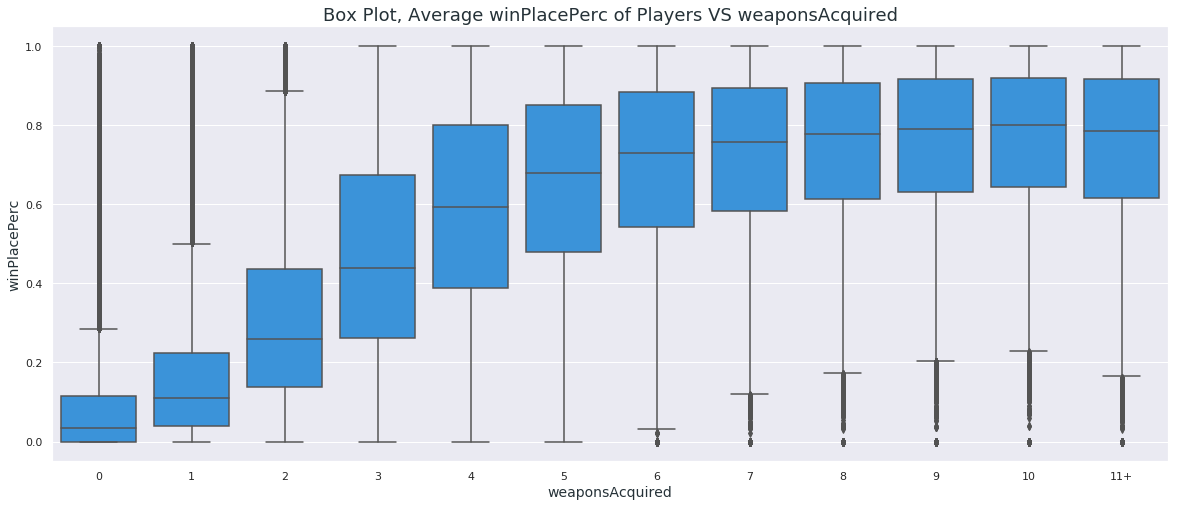

In [20]:
data = train[['weaponsAcquired','winPlacePerc']].copy()
data.loc[data['weaponsAcquired'] >= 11, 'weaponsAcquired'] = '11+'
order = data.groupby('weaponsAcquired').mean().reset_index()['weaponsAcquired']
fig, ax = plt.subplots(figsize=(20,8))
a = sb.boxplot(x='weaponsAcquired', y='winPlacePerc', data=data, ax=ax, color="#2196F3", order=order)
ax.set_xlabel('weaponsAcquired', size=14, color="#263238")
ax.set_ylabel('winPlacePerc', size=14, color="#263238")
ax.set_title('Box Plot, Average winPlacePerc of Players VS weaponsAcquired', size=18, color="#263238")
plt.show()

**Take Away**  Weapons are key to win this game. More the weapons a player has, the higher is the winPlacePerc till 10 weapons after which there is a slight dip.

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


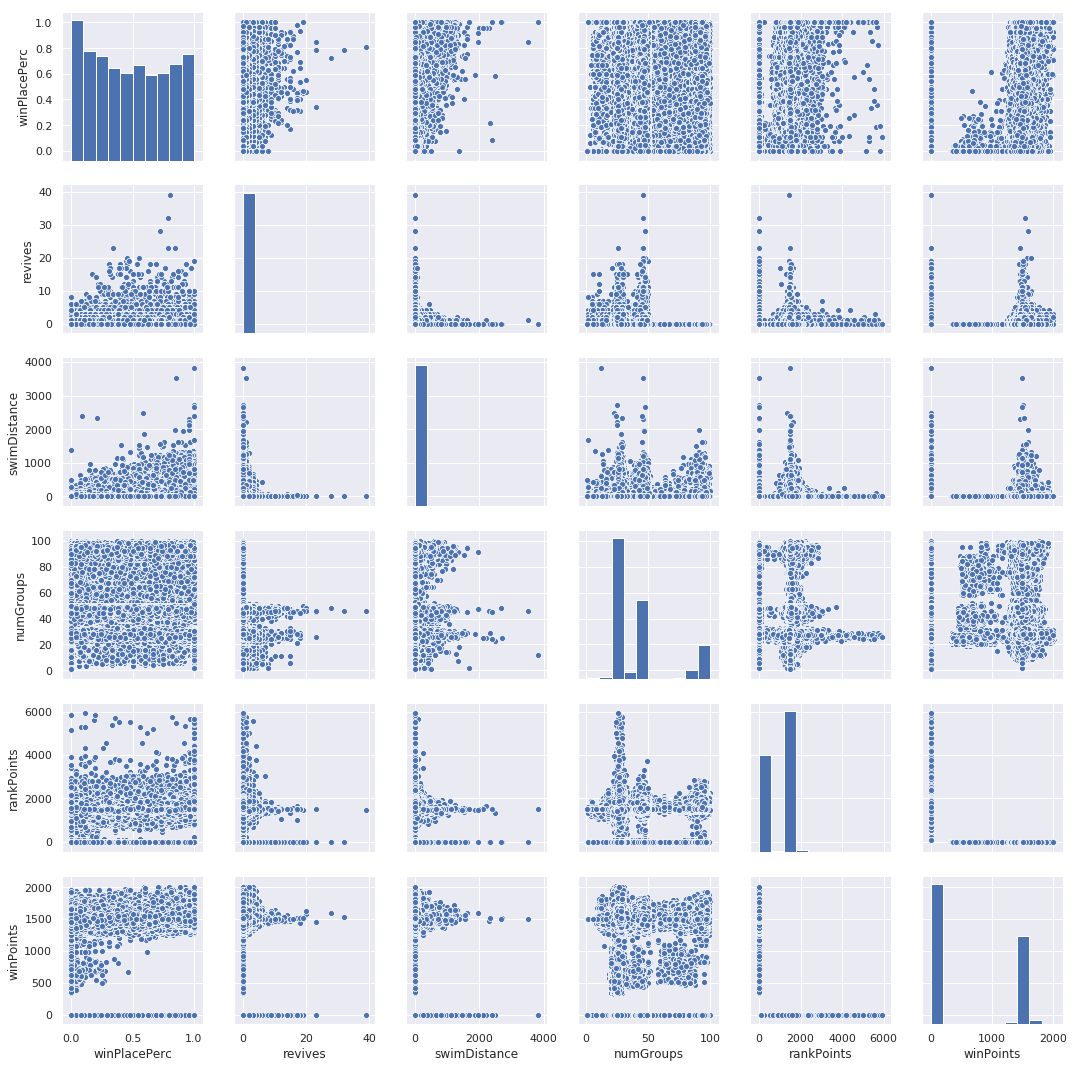

In [21]:
sb.set()
cols = ['winPlacePerc', 'revives', 'swimDistance', 'numGroups', 'rankPoints', 'winPoints']
sb.pairplot(train[cols], size = 2.5)
plt.show()

# 3.Base Model - Random Forest

Categorical Columns 'matchType' indicates that there are 3 type of game modes in PUBG

<br>Solo : The player fights alone</br>
<br>Duo : The player can pair with another player (Maximum one, Not compulsory)</br>
<br>Squad : The player can pair up with atmost 3 other players.</br>
<br>Categories like FPP, normal, TPP and other similar categories can be grouped together as follows</br>

solo <-- [solo,solo-fpp,normal-solo,normal-solo-fpp]
duo <-- [duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp]
squad <-- [squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp]

In [22]:
train['matchType'].replace(['squad-fpp', 'normal-squad-fpp', 'normal-squad', 'flarefpp', 'flaretpp'], 'squad',inplace=True)
train['matchType'].replace(['duo-fpp', 'normal-duo-fpp', 'normal-duo', 'crashfpp', 'crashtpp'], 'duo',inplace=True)
train['matchType'].replace(['solo-fpp','normal-solo','normal-solo-fpp'], 'solo',inplace=True)
test['matchType'].replace(['squad-fpp', 'normal-squad-fpp', 'normal-squad', 'flarefpp', 'flaretpp'], 'squad',inplace=True)
test['matchType'].replace(['duo-fpp', 'normal-duo-fpp', 'normal-duo', 'crashfpp', 'crashtpp'], 'duo',inplace=True)
test['matchType'].replace(['solo-fpp','normal-solo','normal-solo-fpp'], 'solo',inplace=True)

Since the given dataset is really huge, A subset is made with 2 lakh rows for training and is divided as Independent and dependent variables.

In [23]:
train.drop(['Id', 'groupId', 'matchId'], axis=1, inplace = True)
x = train.drop(['winPlacePerc'], axis=1).sample(180000).values
y = train['winPlacePerc'].sample(180000).values

The dataset contains a categorical variable 'matchType' in it. Therefore, categorical encoding is performed

In [24]:
x_linear = LabelEncoder()
x[:, 12] = x_linear.fit_transform(x[:, 12])
hot_enc = OneHotEncoder(categorical_features=[12])
x = hot_enc.fit_transform(x).toarray()
# To avoid Dummy trap
x = x[:, 1:]
# Split the data into train and test set
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = .2, random_state = 0)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


The train set is fitted on to the Random Forest Regressor and the hyper parameters are tuned using GridSearchCV. The grid search code section is removed here to make the final commit faster. K Fold cross validation retured a mean absolute error of 0.06464 which is approximately 6.4%.

In [25]:
regressor = RandomForestRegressor(n_estimators = 1000,
                                  min_samples_split=5,
                                  max_depth = 19,
                                  random_state=101,
                                  n_jobs = -1)
regressor.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=101, verbose=0, warm_start=False)

**Feature Importance for the Random Forest Model**

Permutaition Importance test is performed on the random forest regression model and the result is interpreted as a histogram below. 'killPoints' is the most important variable in the model followed by 'walkDistance'. headShotKils, roadKills, vehiclesDestroyed have relatively no importance in the model's win prediction

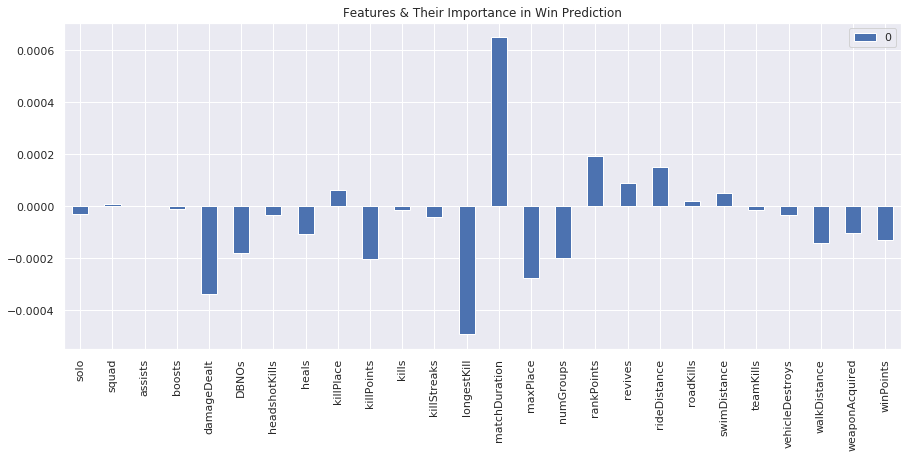

In [26]:
imp_vals,_ = feature_importance_permutation(predict_method=regressor.predict,
                                          X=test_x,
                                          y=test_y, metric='r2',
                                          num_rounds=1)
feature_importance = pd.DataFrame(imp_vals, index=['solo','squad','assists','boosts','damageDealt',
                                  'DBNOs','headshotKills','heals','killPlace',
                                  'killPoints','kills','killStreaks',
                                  'longestKill','matchDuration','maxPlace',
                                  'numGroups','rankPoints','revives',
                                  'rideDistance','roadKills','swimDistance',
                                  'teamKills','vehicleDestroys','walkDistance',
                                  'weaponAcquired','winPoints'])
feature_importance.plot(kind='bar', figsize=(15,6),
                       title='Features & Their Importance in Win Prediction')

Removing non relevent columns(Cross Validation is performed with scoring MAE and adjusted R2 after removing each columns to find those columns that improve the model). However, the code is removed to prevent memory error and make commit faster. Refitting regressor,

In [27]:
x = train.drop(['headshotKills',
                      'revives','swimDistance','teamKills','winPlacePerc'], axis=1).head(150000).values
y = train['winPlacePerc'].head(150000).values
x_linear = LabelEncoder()
x[:, 11] = x_linear.fit_transform(x[:, 11])
hot_enc = OneHotEncoder(categorical_features=[11])
x = hot_enc.fit_transform(x).toarray()
x_test = test.drop(['Id', 'groupId', 'matchId','headshotKills',
                      'revives','swimDistance','teamKills'], axis=1).values
x_linear_new = LabelEncoder()
x_test[:, 11] = x_linear_new.fit_transform(x_test[:, 11])
hot_enc_new = OneHotEncoder(categorical_features=[11])
x_test = hot_enc_new.fit_transform(x_test).toarray()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data w

In [28]:
regressor = RandomForestRegressor(n_estimators = 1000,
                                  min_samples_split=5,
                                  max_depth = 19,
                                  random_state=101,
                                  n_jobs = -1)

regressor.fit(x,y)
y_test_pred=regressor.predict(x_test)
submissions = test['Id']
submissions=pd.DataFrame(submissions)
submissions['winPlacePerc']=pd.DataFrame(y_test_pred)
submissions.to_csv('submission.csv', index=False)

# **The hyper parameter tuned and feature reduced base model returned an improved score of 0.0608.**

# **Due to memory and time constraints in Kaggle kernels, the complete model is divided in to two sections. **

# **For the second section containing Feature Engineering and LightGBM model with a much  better prediction, <a href="https://www.kaggle.com/iamarjunchandra/pubg-feature-engineering-lightgbm-explained">Click Here!</a>**